## Developing LLM to detect AI generated Text

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a large language model capable of detecting AI generated text.

We're going to take the following approach:

1. Problem defination
2. Data
3. Evaluation
4. Features
5. Modelling
5. Experimentation
6. Sumbission

### 1. Problem defination:
> distinguish AI generated text from human-written text.


### 2. Data
> Data is available on Kaggle: https://kaggle.com/competitions/llm-detect-ai-generated-text

### 3. Evaluation:
- Submissions will be evaluated on area under the ROC curve between the predicted probability and the observed target (https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview).

### 4. Features:
#### File and Field Information

- **{test|train}_essays.csv**
 - id - A unique identifier for each essay.
 - prompt_id - Identifies the prompt the essay was written in response to.
 - text - The essay text itself.
 - generated - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.
 
- **train_prompts.csv** - Essays were written in response to information in these fields.
 - prompt_id - A unique identifier for each prompt.
 - prompt_name - The title of the prompt.
 - instructions - The instructions given to students.
 - source_text - The text of the article(s) the essays were written in response to, in Markdown format. Significant paragraphs are enumerated by a numeral preceding the paragraph on the same line, as in 0 Paragraph one.\n\n1 Paragraph two.. Essays sometimes refer to a paragraph by its numeral. Each article is preceded with its title in a heading, like # Title. When an author is indicated, their name will be given in the title after by. Not all articles have authors indicated. An article may have subheadings indicated like ## Subheading.

### 5. Modeling: Now we will find the best large language model to detect AI generated text.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
!pip install --upgrade tensorflow
import tensorflow as tf
import tensorflow.compat.v1 as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import warnings

C:\Users\Hero Clament\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load data
df = pd.read_csv('train_essays.csv')

In [3]:
df['generated'].value_counts()

0    1375
1       3
Name: generated, dtype: int64

In [4]:
X = df['text'].values
y = df['generated'].values

In [5]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

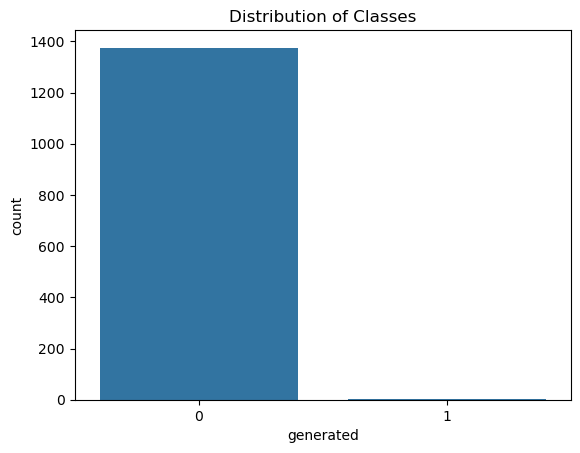

In [6]:
# Exploratory Data Analysis (EDA)
sns.countplot(x='generated', data=df)
plt.title('Distribution of Classes')
plt.show()

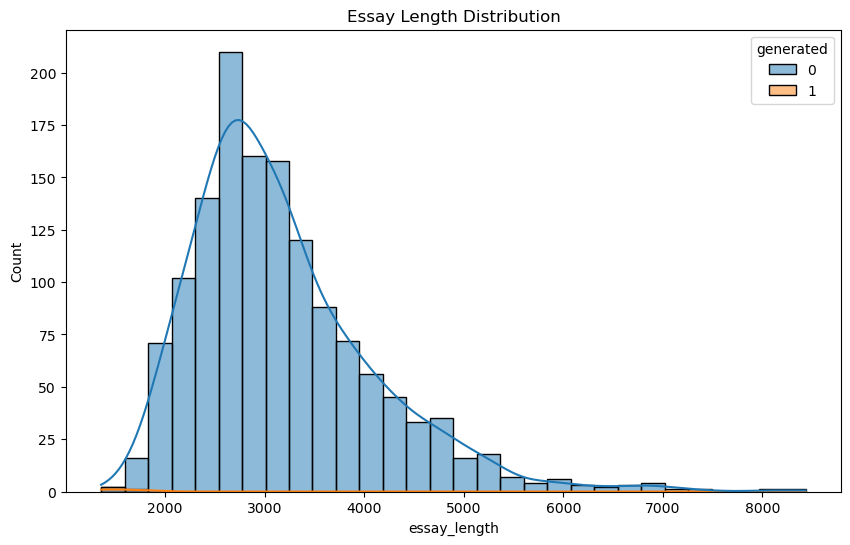

In [7]:
df['essay_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df, x='essay_length', hue='generated', bins=30, kde=True)
plt.title('Essay Length Distribution')
plt.show()

In [8]:
# TF-IDF features for XGBoost
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)

In [9]:
# Train XGBoost model
xgb = XGBClassifier(n_estimators=1000)
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.01]
}
gs = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1, verbose=1)
gs.fit(X_train_tfidf, y_train)
xgb_best = gs.best_estimator_
xgb_best.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Hero Clament\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [10]:
# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')
graph = tf.compat.v1.get_default_graph()
warnings.filterwarnings("ignore", category=DeprecationWarning)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [11]:
# Tokenize and encode the training data
X_train_enc = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf')
y_train_enc = np.array(y_train)

In [12]:
# Tokenize and encode the validation data
X_valid_enc = tokenizer(X_valid.tolist(), padding=True, truncation=True, return_tensors='tf')
y_valid_enc = np.array(y_valid)

In [13]:
# Fine-tune RoBERTa model
roberta_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[tf.keras.metrics.BinaryAccuracy()])

In [14]:
# Convert BatchEncoding to numpy arrays for compatibility with the hash function
X_train_enc_numpy = {
    'input_ids': np.array(X_train_enc['input_ids']),
    'attention_mask': np.array(X_train_enc['attention_mask'])
}
X_valid_enc_numpy = {
    'input_ids': np.array(X_valid_enc['input_ids']),
    'attention_mask': np.array(X_valid_enc['attention_mask'])
}

roberta_model.fit(X_train_enc_numpy, y_train_enc, validation_data=(X_valid_enc_numpy, y_valid_enc), epochs=3, batch_size=8)

Epoch 1/3

138/138 [==============================] - 1442s 10s/step - loss: 0.0281 - binary_accuracy: 0.9982 - val_loss: 0.0559 - val_binary_accuracy: 0.9964
Epoch 2/3
138/138 [==============================] - 1333s 10s/step - loss: 0.0280 - binary_accuracy: 0.9982 - val_loss: 0.0559 - val_binary_accuracy: 0.9964
Epoch 3/3
138/138 [==============================] - 1314s 10s/step - loss: 0.0280 - binary_accuracy: 0.9982 - val_loss: 0.0559 - val_binary_accuracy: 0.9964


In [15]:
# Evaluate RoBERTa model on validation set
roberta_probs_valid = roberta_model.predict(X_valid_enc_numpy)['logits'][:, 0]
roberta_auc_valid = roc_auc_score(y_valid, roberta_probs_valid)
print(f'RoBERTa AUC on validation set: {roberta_auc_valid}')

9/9 [==============================] - 95s 10s/step
RoBERTa AUC on validation set: 0.9963636363636363


In [16]:
# Save the RoBERTa model
roberta_model.save_pretrained("roberta-model")

In [30]:
# Create download links for all files in the directory
from IPython.display import FileLinks

# Specify the directory where the model is saved
model_directory = "roberta-model"

# Create download links for all files in the directory
FileLinks(model_directory)

roberta-model/
  config.json
  tf_model.h5

In [31]:
import shutil

# Specify the directory where the model is saved
model_directory = "roberta-model"

# Create a zip archive
shutil.make_archive(model_directory, 'zip', model_directory)

'D:\\heart-disease-pro\\LLM - Detect AI Generated Text\\roberta-model.zip'

In [18]:
# Generate predictions using the trained models
#roberta_probs_test = roberta_model.predict(X_test_enc['input_ids'])['logits'][:, 0]
#xgb_probs_test = xgb_best.predict_proba(X_test_tfidf)[:, 1]

roberta_probs_test = roberta_model.predict(X_train_enc_numpy)['logits'][:, 0]
xgb_probs_test = xgb_best.predict_proba(X_train_tfidf)[:, 1]

35/35 [==============================] - 367s 10s/step


In [19]:
# Ensemble predictions
# Ensemble predictions
xgb_probs_valid = xgb_best.predict_proba(X_valid_tfidf)[:, 1]
ensemble_probs_valid = 0.6 * xgb_probs_valid + 0.4 * roberta_probs_valid

# Ensemble predictions
ensemble_probs_test = 0.6 * xgb_probs_test + 0.4 * roberta_probs_test

# Ensemble predictions
#ensemble_probs_test = 0.6 * xgb_probs_test + 0.4 * roberta_probs_test

In [20]:
#ensemble_auc_valid = roc_auc_score(y_valid, ensemble_probs_valid)
#print(f'Ensemble AUC on validation set: {ensemble_auc_valid}')

#ensemble_auc_valid = roc_auc_score(y_valid_enc, ensemble_probs_test)
ensemble_auc_valid = roc_auc_score(y_valid_enc, ensemble_probs_valid)
print(f'Ensemble AUC on validation set: {ensemble_auc_valid}')

Ensemble AUC on validation set: 0.9927272727272727


In [21]:
# Model Evaluation (ROC Curve)

fpr, tpr, thresholds = roc_curve(y_valid, ensemble_probs_valid)
roc_auc = auc(fpr, tpr)

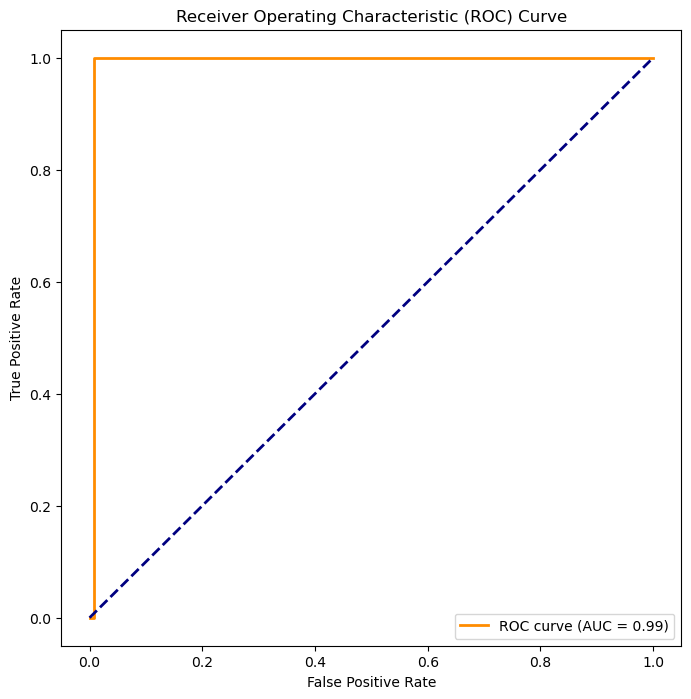

In [22]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
# Load the test data
test_df=pd.read_csv('test_essays.csv')
X_test = test_df['text'].values

In [24]:
# TF-IDF features for XGBoost
X_test_tfidf = tfidf.transform(X_test)

In [25]:
# Tokenize and encode the test data for RoBERTa

X_test_enc = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='tf')

In [26]:
# Generate predictions using the trained models on the test set

roberta_probs_test = roberta_model(X_test_enc)['logits'][:, 0]
roberta_probs_test = tf.nn.sigmoid(roberta_probs_test)
roberta_probs_test = roberta_probs_test.numpy().flatten()

xgb_probs_test = xgb_best.predict_proba(X_test_tfidf)[:, 1]

In [27]:
# Ensemble predictions


ensemble_probs_test = 0.6 * xgb_probs_test + 0.4 * roberta_probs_test


In [28]:
# Submission dataframe

submission_df = pd.DataFrame({'id': test_df['id'], 'generated': ensemble_probs_test})

In [29]:
# Create submission file

submission_df.to_csv('submission.csv', index=False)
print('Submission file saved!')

Submission file saved!
